# ODE Fitting with DiffSL

**Objectives:**
- Understand the DiffsolBuilder API
- Learn DiffSL syntax for defining ODEs
- Fit parameters of a logistic growth model
- Visualise model fits and residuals

## Introduction

The logistic growth model describes population dynamics with limited resources:

$$\frac{dy}{dt} = r \cdot y \cdot \left(1 - \frac{y}{k}\right)$$

where:
- $y$ is the population
- $r$ is the growth rate
- $k$ is the carrying capacity (maximum population)

This tutorial demonstrates parameter fitting using experimental or simulated data.

In [ ]:
# Import plotting utilities
import diffid
import matplotlib.pyplot as plt
import numpy as np
from diffid.plotting import ode_fit

## Define the ODE in DiffSL

DiffSL (Differential Specification Language) is a concise syntax for ODEs:

In [2]:
dsl_model = """
in_i {r = 1, k = 1 }
u_i { y = 0.1 }
F_i { (r * y) * (1 - (y / k)) }
"""

print("DiffSL Model Definition:")
print("=" * 50)
print(dsl_model)
print("\nExplanation:")
print("  in_i {r = 1, k = 1 }         → Parameters to fit")
print("  u_i { y = 0.1 }     → Initial condition: y(0) = 0.1")
print("  F_i { ... }         → Right-hand side: dy/dt = ...")

DiffSL Model Definition:

in_i {r = 1, k = 1 }
u_i { y = 0.1 }
F_i { (r * y) * (1 - (y / k)) }


Explanation:
  in_i {r = 1, k = 1 }        → Parameters to fit
  u_i { y = 0.1 }     → Initial condition: y(0) = 0.1
  F_i { ... }         → Right-hand side: dy/dt = ...


## Generate Synthetic Data

For this tutorial, we'll create synthetic data from the logistic function:

In [ ]:
# Time points
t_span = np.linspace(0, 4, 100)

# True logistic growth solution with known parameters
# y(t) = y0 * exp(r*t) / (1 + y0 * (exp(r*t) - 1) / k)
y0 = 0.1
r_true = 1.0
k_true = 1.0

# Generate clean data
exp_rt = np.exp(r_true * t_span)
y_data = y0 * exp_rt / (1 + y0 * (exp_rt - 1) / k_true)

# Add some noise
np.random.seed(42)
noise_level = 0.01
y_noisy = y_data + np.random.normal(0, noise_level, size=y_data.shape)

# Diffid expects data as [time, observation] columns
data = np.column_stack((t_span, y_noisy))

print(f"Generated {len(t_span)} data points")
print(f"Time range: [{t_span[0]:.2f}, {t_span[-1]:.2f}]")
print(f"Value range: [{y_noisy.min():.3f}, {y_noisy.max():.3f}]")
print(f"Noise level: {noise_level}")
print(f"\nTrue parameters: r = {r_true}, k = {k_true}")

## Visualise the Data

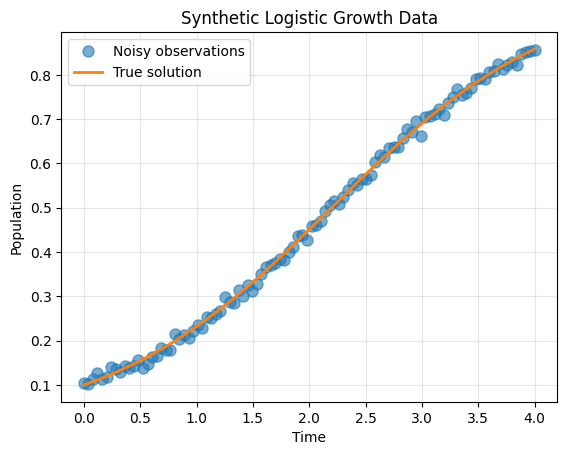

In [4]:
fig, ax = ode_fit(
    t_span,
    y_noisy,
    t_span,
    y_data,
    title="Synthetic Logistic Growth Data",
    xlabel="Time",
    ylabel="Population",
    show=False,
)

# Update legend
ax.legend(["Noisy observations", "True solution"])
plt.show()

## Build the Optimisation Problem

Use `DiffsolBuilder` for ODE parameter fitting:

In [ ]:
# Create builder
builder = (
    diffid.DiffsolBuilder()
    .with_diffsl(dsl_model)
    .with_data(data)
    .with_tolerances(1e-6, 1e-8)  # Relative and absolute tolerances
    .with_parameter("r", 10.0)  # Initial guess
    .with_parameter("k", 10.0)  # Initial guess (deliberately wrong)
    .with_parallel(True)  # Enable parallel evaluation
)

problem = builder.build()

print("Problem built successfully!")
print("\nInitial parameter guesses: r = 50.0, k = 50.0")
print(f"(Far from true values: r = {r_true}, k = {k_true})")

## Optimise with CMA-ES

CMA-ES works well for ODE parameter fitting:

In [ ]:
# Create optimiser
optimiser = diffid.CMAES().with_max_iter(1000).with_threshold(1e-12)

# Run optimisation
result = optimiser.run(problem, problem.initial_values())

print("\n" + "=" * 60)
print("OPTIMISATION RESULTS")
print("=" * 60)
print(f"Success: {result.success}")
print("\nFitted parameters:")
print(f"  r = {result.x[0]:.6f}  (true: {r_true})")
print(f"  k = {result.x[1]:.6f}  (true: {k_true})")
print("\nOptimisation details:")
print(f"  Final cost: {result.value:.3e}")
print(f"  Iterations: {result.iterations}")
print(f"  Function evaluations: {result.evaluations}")
print(f"  Time: {result.time.microseconds / 1e3:.3f} milliseconds")
print(f"  Message: {result.message}")

# Calculate parameter errors
r_error = abs(result.x[0] - r_true) / r_true * 100
k_error = abs(result.x[1] - k_true) / k_true * 100
print("\nParameter errors:")
print(f"  r: {r_error:.3f}%")
print(f"  k: {k_error:.3f}%")

## Visualise the Fit

Let's plot the fitted model against the data:

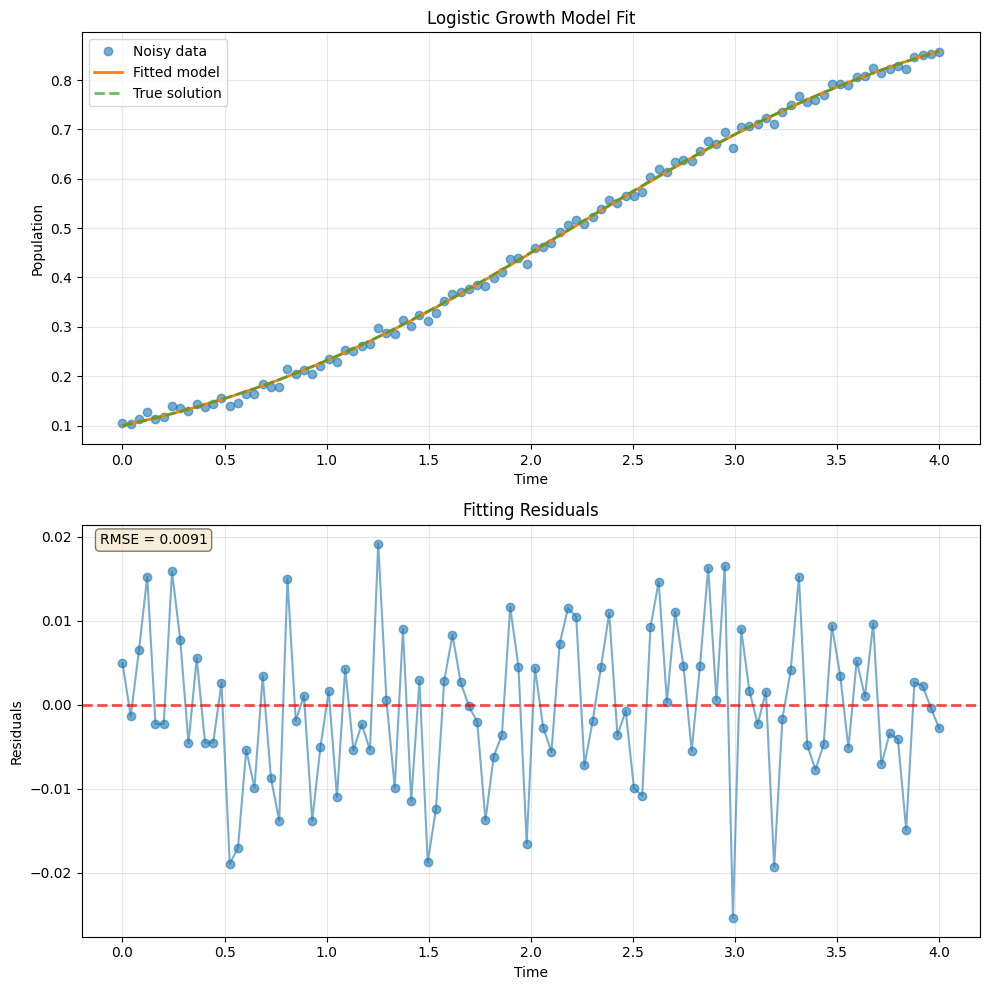


Fit quality:
  RMSE: 0.009066
  Max residual: 0.025379
  Mean residual: -0.000468


In [7]:
# Generate predictions with fitted parameters
r_fit, k_fit = result.x
exp_rt_fit = np.exp(r_fit * t_span)
y_fit = y0 * exp_rt_fit / (1 + y0 * (exp_rt_fit - 1) / k_fit)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Top: Data and fits
ax1 = axes[0]
ax1.plot(t_span, y_noisy, "o", label="Noisy data", alpha=0.6, markersize=6)
ax1.plot(t_span, y_fit, "-", label="Fitted model", linewidth=2)
ax1.plot(t_span, y_data, "--", label="True solution", linewidth=2, alpha=0.7)
ax1.set_xlabel("Time")
ax1.set_ylabel("Population")
ax1.set_title("Logistic Growth Model Fit")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom: Residuals
ax2 = axes[1]
residuals = y_noisy - y_fit
ax2.plot(t_span, residuals, "o-", alpha=0.6)
ax2.axhline(0, color="r", linestyle="--", linewidth=2, alpha=0.7)
ax2.set_xlabel("Time")
ax2.set_ylabel("Residuals")
ax2.set_title("Fitting Residuals")
ax2.grid(True, alpha=0.3)

# Add statistics
rmse = np.sqrt(np.mean(residuals**2))
ax2.text(
    0.02,
    0.98,
    f"RMSE = {rmse:.4f}",
    transform=ax2.transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)

plt.tight_layout()
plt.show()

print("\nFit quality:")
print(f"  RMSE: {rmse:.6f}")
print(f"  Max residual: {np.abs(residuals).max():.6f}")
print(f"  Mean residual: {np.mean(residuals):.6f}")

## Comparing Different Initial Guesses

Let's see how different starting points affect convergence:

In [8]:
# Try several initial guesses
initial_guesses = [
    [0.5, 0.5],
    [2.0, 2.0],
    [10.0, 10.0],
    [100.0, 100.0],
]

print("\n" + "=" * 70)
print("INITIAL GUESS SENSITIVITY")
print("=" * 70)
print(f"{'Initial [r, k]':<20} {'Final [r, k]':<30} {'Iterations':<12} {'Success'}")
print("-" * 70)

for guess in initial_guesses:
    result = optimiser.run(problem, guess)
    final_str = f"[{result.x[0]:.4f}, {result.x[1]:.4f}]"
    guess_str = f"{guess}"
    print(f"{guess_str:<20} {final_str:<30} {result.iterations:<12} {result.success}")

print(f"\nTrue values: [r, k] = [{r_true}, {k_true}]")


INITIAL GUESS SENSITIVITY
Initial [r, k]       Final [r, k]                   Iterations   Success
----------------------------------------------------------------------
[0.5, 0.5]           [0.9967, 1.0029]               73           True
[2.0, 2.0]           [0.9967, 1.0029]               77           True
[10.0, 10.0]         [0.9967, 1.0029]               183          True
[100.0, 100.0]       [0.5947, 23.7961]              410          True

True values: [r, k] = [1.0, 1.0]


## Comparing Optimisers

Let's compare different optimization algorithms:

In [ ]:
optimisers = {
    "Nelder-Mead": diffid.NelderMead().with_max_iter(1000),
    "CMA-ES": diffid.CMAES().with_max_iter(500),
    "Adam": diffid.Adam().with_max_iter(1000).with_step_size(0.01),
}

initial = [2.0, 2.0]

print("\n" + "=" * 80)
print("OPTIMISER COMPARISON")
print("=" * 80)
print(
    f"{'Algorithm':<15} {'r (fitted)':<15} {'k (fitted)':<15} {'Cost':<15} {'Iters':<8} {'Time (s)'}"
)
print("-" * 80)

for name, opt in optimisers.items():
    result = opt.run(problem, initial)
    print(
        f"{name:<15} {result.x[0]:<15.6f} {result.x[1]:<15.6f} "
        f"{result.value:<15.3e} {result.iterations:<8} {result.time.microseconds / 1e6:.3f}"
    )

print(f"\nTrue values:    {r_true:<15.6f} {k_true:<15.6f}")

## Understanding DiffSL Syntax

Let's explore more complex DiffSL examples:

In [10]:
# Example 1: Multiple state variables (Lotka-Volterra)
predator_prey = """
in_i { alpha = 1, beta = 0.1, gamma = 1.5, delta = 0.075 }
u_i {
    prey = 10.0
    predator = 5.0
}
F_i {
    alpha * prey - beta * prey * predator,
    delta * prey * predator - gamma * predator
}
out_i { prey, predator }
"""

print("Example: Predator-Prey Model (Lotka-Volterra)")
print("=" * 50)
print(predator_prey)

# Example 2: With algebraic equations
with_algebra = """
in_i { k1 = 0.5, k2 = 0.3 }
u_i { A = 1.0 }
F_i {
    -k1 * A,
    k1 * A - k2 * B
}
out_i { A, B }
"""

print("\nExample: Sequential Reactions (A → B → C)")
print("=" * 50)
print(with_algebra)

Example: Predator-Prey Model (Lotka-Volterra)

in_i { alpha = 1, beta = 0.1, gamma = 1.5, delta = 0.075 }
u_i {
    prey = 10.0
    predator = 5.0
}
F_i {
    alpha * prey - beta * prey * predator,
    delta * prey * predator - gamma * predator
}
out_i { prey, predator }


Example: Sequential Reactions (A → B → C)

in_i { k1 = 0.5, k2 = 0.3 }
u_i { A = 1.0 }
F_i {
    -k1 * A,
    k1 * A - k2 * B
}
out_i { A, B }



## Key Takeaways

1. **DiffsolBuilder** is used for ODE parameter fitting
2. **DiffSL** provides concise ODE syntax: `in`, `u_i`, `F_i`
3. Data format: `[time, observation(s)]` in columns
4. **CMA-ES** typically works well for ODE fitting
5. Parallel evaluation improves performance
6. Always check residuals to assess fit quality

## Next Steps

- [Parameter Uncertainty](parameter_uncertainty.ipynb) - Quantify parameter uncertainty with MCMC
- [DiffSL Backend Guide](../../guides/diffsol-backend.md) - Dense vs sparse solvers
- [Custom Solvers](../../guides/custom-solvers.md) - Using JAX/Diffrax or Julia

## Exercises

1. **Add Noise**: Increase `noise_level` to 0.05 and see how it affects fitting

2. **Different Model**: Implement exponential decay: $\frac{dy}{dt} = -k \cdot y$

3. **Multiple Variables**: Try fitting the predator-prey model with synthetic data

4. **Sparse Data**: Reduce the number of data points (e.g., 20 instead of 100) and observe the impact